In [2]:
# setup
from mlwpy import *
%matplotlib inline

iris = datasets.load_iris()

tts = skms.train_test_split(iris.data, iris.target,
                           test_size=.33, random_state=21)

(iris_train_ftrs, iris_test_ftrs,
iris_train_tgt, iris_test_tgt) = tts

### 6.1 Baseline Classifiers

In [3]:
# normal usage: build-fit-predict-evaluate
baseline = dummy.DummyClassifier(strategy="most_frequent")
baseline.fit(iris_train_ftrs, iris_train_tgt)
base_preds = baseline.predict(iris_test_ftrs)

base_acc = metrics.accuracy_score(base_preds, iris_test_tgt)
print(base_acc)

0.3


In [4]:
strategies = ['constant', 'uniform', 'stratified',
             'prior', 'most_frequent']

# set up args to create different DummyClassifier strategies
baseline_args = [{'strategy':s} for s in strategies]
baseline_args[0]['constant'] = 0 # class 0 is setosa

accuracies = []
for bla in baseline_args:
    baseline = dummy.DummyClassifier(**bla)
    baseline.fit(iris_train_ftrs, iris_train_tgt)
    base_preds = baseline.predict(iris_test_ftrs)
    accuracies.append(metrics.accuracy_score(base_preds, iris_test_tgt))
    
display(pd.DataFrame({'accuracy':accuracies}, index=strategies))
#uniform and stratified will return different results if rerun bc they are 
#randomized methods - others return fixed vals

,accuracy
constant,0.3600
uniform,0.3800
stratified,0.3400
prior,0.3000
most_frequent,0.3000


### 6.2 More Metrics for Classification

In [5]:
# helpful stdlib tool for cleaning up printouts
import textwrap
print(textwrap.fill(str(sorted(metrics.SCORERS.keys())),
     width=70))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score',
'average_precision', 'balanced_accuracy', 'completeness_score',
'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples',
'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score',
'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples',
'jaccard_weighted', 'max_error', 'mutual_info_score',
'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error',
'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance',
'neg_mean_poisson_deviance', 'neg_mean_squared_error',
'neg_mean_squared_log_error', 'neg_median_absolute_error',
'neg_root_mean_squared_error', 'normalized_mutual_info_score',
'precision', 'precision_macro', 'precision_micro',
'precision_samples', 'precision_weighted', 'r2', 'rand_score',
'recall', 'recall_macro', 'recall_micro', 'recall_samples',
'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted',
'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy',
'v_measure_score']


In [6]:
knn = neighbors.KNeighborsClassifier()

# help(knn.score) #verbose but complete

print(knn.score.__doc__.splitlines()[0])
print('\n---and---\n')
print('\n'.join(knn.score.__doc__.splitlines()[-6:]))



---and---


        Returns
        -------
        score : float
            Mean accuracy of ``self.predict(X)`` wrt. `y`.
        


### 6.2.4 Confusion Matrix

In [7]:
tgt_preds = (neighbors.KNeighborsClassifier()
                      .fit(iris_train_ftrs, iris_train_tgt)
                      .predict(iris_test_ftrs))
             
print("accuracy:", metrics.accuracy_score(iris_test_tgt,
                                         tgt_preds))
             
cm = metrics.confusion_matrix(iris_test_tgt, 
                              tgt_preds)

print("confusion matrix:", cm, sep='\n')

accuracy: 0.94
confusion matrix:
[[18  0  0]
 [ 0 16  1]
 [ 0  2 13]]


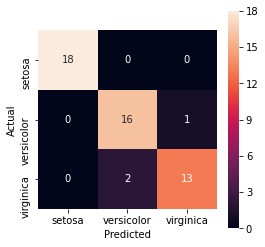

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
cm = metrics.confusion_matrix(iris_test_tgt, tgt_preds)
ax = sns.heatmap(cm, annot=True, square=True,
                xticklabels=iris.target_names,
                yticklabels=iris.target_names)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

### 6.2.5 Multiclass Averaging

In [9]:
macro_prec = metrics.precision_score(iris_test_tgt,
                                    tgt_preds,
                                    average='macro')

print("macro:", macro_prec)

cm = metrics.confusion_matrix(iris_test_tgt, tgt_preds)
n_labels = len(iris.target_names)

print("should equal 'macro avg':",
     # correct         # column           # columns
     (np.diag(cm) / cm.sum(axis=0)).sum()/ n_labels)


macro: 0.9391534391534391
should equal 'macro avg': 0.9391534391534391


In [10]:
print("micro:", metrics.precision_score(iris_test_tgt,
                                       tgt_preds,
                                       average='micro'))

cm = metrics.confusion_matrix(iris_test_tgt, tgt_preds)
print("should equal avg='micro':",
     # TP.sum()        / (TP&FP).sum() -->
     # all correct     / all preds
     np.diag(cm).sum() / cm.sum())

micro: 0.94
should equal avg='micro': 0.94


In [11]:
print(metrics.classification_report(iris_test_tgt,
                                   tgt_preds))
#average is a weighted macro average (see text)

#verify sums-across-rows
cm = metrics.confusion_matrix(iris_test_tgt, tgt_preds)
print("row counts equal support:", cm.sum(axis=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.89      0.94      0.91        17
           2       0.93      0.87      0.90        15

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50

row counts equal support: [18 17 15]


### 6.3.2 Binary ROC

In [12]:
is_versicolor = iris.target == 1

tts_1c = skms.train_test_split(iris.data, is_versicolor,
                              test_size=.33, random_state = 21)

(iris_1c_train_ftrs, iris_1c_test_ftrs,
iris_1c_train_tgt, iris_1c_test_tgt) = tts_1c

# build, fit, predict (probability scores) for NB model
gnb = naive_bayes.GaussianNB()
prob_true = (gnb.fit(iris_1c_train_ftrs, iris_1c_train_tgt)
                .predict_proba(iris_1c_test_ftrs)[:,1])

FPR : [0.     0.     0.     0.0606 0.0606 0.1212 0.1212 0.1818 1.    ]
TPR : [0.     0.0588 0.8824 0.8824 0.9412 0.9412 1.     1.     1.    ]


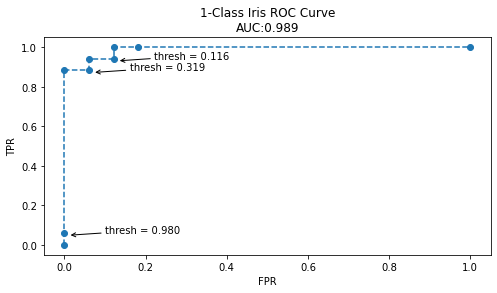

In [13]:
fpr, tpr, thresh = metrics.roc_curve(iris_1c_test_tgt,
                                    prob_true)
auc = metrics.auc(fpr, tpr)
print("FPR : {}".format(fpr),
      "TPR : {}".format(tpr), sep='\n')

# create the main graph
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(fpr, tpr, 'o--')
ax.set_title("1-Class Iris ROC Curve\nAUC:{:.3f}".format(auc))
ax.set_xlabel("FPR")
ax.set_ylabel("TPR");

#label some points with their respective thresholds
investigate = np.array([1, 3, 5])
for idx in investigate:
    th, f, t = thresh[idx], fpr[idx], tpr[idx]
    ax.annotate('thresh = {:.3f}'.format(th),
               xy=(f+.01, t-.01), xytext=(f+.1, t),
               arrowprops = {'arrowstyle':'->'})

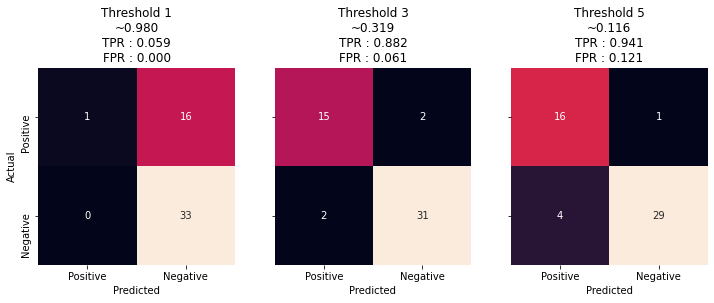

In [14]:
title_fmt = "Threshold {}\n~{:5.3f}\nTPR : {:.3f}\nFPR : {:.3f}"

pn = ['Positive', 'Negative']
add_args = {'xticklabels': pn,
           'yticklabels': pn,
           'square': True}

fig, axes = plt.subplots(1, 3, sharey = True, figsize=(12,4))
for ax, thresh_idx in zip(axes.flat, investigate):
    preds_at_th = prob_true < thresh[thresh_idx]
    cm = metrics.confusion_matrix(1-iris_1c_test_tgt, preds_at_th)
    sns.heatmap(cm, annot=True, cbar=False, ax=ax,
               **add_args)
    
    ax.set_xlabel('Predicted')
    ax.set_title(title_fmt.format(thresh_idx,
                                 thresh[thresh_idx],
                                 tpr[thresh_idx],
                                 fpr[thresh_idx]))
    
axes[0].set_ylabel('Actual');

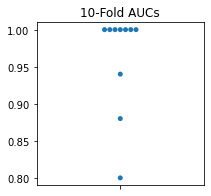

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
model = neighbors.KNeighborsClassifier(3)
cv_auc = skms.cross_val_score(model, iris.data, iris.target==1,
                              scoring='roc_auc', cv=10)
ax = sns.swarmplot(cv_auc, orient='v')
ax.set_title('10-Fold AUCs');

### 6.3.4 Multiclass Learners, One-versus-Rest, and ROC

In [16]:
checkout = [0, 50, 100]
print("Original Encoding")
print(iris.target[checkout])

Original Encoding
[0 1 2]


In [119]:
len(iris.target)

150

In [17]:
print("'Multi-label' Encoding")
print(skpre.label_binarize(iris.target, [0, 1, 2])[checkout])

'Multi-label' Encoding
[[1 0 0]
 [0 1 0]
 [0 0 1]]


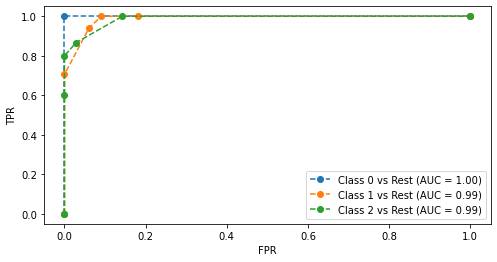

In [18]:
iris_multi_tgt = skpre.label_binarize(iris.target, [0, 1, 2])

#im --> "iris multi"
(im_train_ftrs, im_test_ftrs,
im_train_tgt, im_test_tgt) = skms.train_test_split(iris.data,
                                                  iris_multi_tgt,
                                                  test_size=.33,
                                                  random_state=21)

#knn wrapped up in one-versus-rest (3 classifiers)
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
ovr_knn = skmulti.OneVsRestClassifier(knn)
preds_probs = (ovr_knn.fit(im_train_ftrs, im_train_tgt)
                      .predict_proba(im_test_ftrs))

#make ROC plots
lbl_fmt = "Class {} vs Rest (AUC = {:.2f})"
fig, ax = plt.subplots(figsize=(8,4))
for cls in [0, 1, 2]:
    fpr, tpr, _ = metrics.roc_curve(im_test_tgt[:,cls],
                                   preds_probs[:,cls])
    label = lbl_fmt.format(cls, metrics.auc(fpr, tpr))
    ax.plot(fpr, tpr, 'o--', label=label)
ax.legend()
ax.set_xlabel("FPR")
ax.set_ylabel("TPR");

### 6.4 Multiclass: One Vs. One

In [111]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
ovo_knn = skmulti.OneVsOneClassifier(knn)

pred_scores = (ovo_knn.fit(iris_train_ftrs, iris_train_tgt)
                      .decision_function(iris_test_ftrs))
df = pd.DataFrame(pred_scores)
df['class'] = df.values.argmax(axis=1)
display(df.head())

,0,1,2,class
0,-0.2222,2.1667,1.1667,1
1,2.0000,1.0000,0.0000,0
2,2.0000,1.0000,0.0000,0
3,2.0000,1.0000,0.0000,0
4,-0.2222,2.1667,1.1667,1


In [112]:
print(len(im_test_tgt))
print(len(pred_scores))

50
50


In [113]:
mi = pd.MultiIndex([['Class Indicator', 'Vote'], [0, 1, 2]],
                  [[0]*3+[1]*3, list(range(3)) * 2])
df = pd.DataFrame(np.c_[im_test_tgt, pred_scores],
                 columns=mi)
display(df.head())

Class Indicator                                            \
                     0                    1                    2   
0               0.0000               1.0000               0.0000   
1               1.0000               0.0000               0.0000   
2               1.0000               0.0000               0.0000   
3               1.0000               0.0000               0.0000   
4               0.0000               1.0000               0.0000   

                  Vote                                            
                     0                    1                    2  
0              -0.2222               2.1667               1.1667  
1               2.0000               1.0000               0.0000  
2               2.0000               1.0000               0.0000  
3               2.0000               1.0000               0.0000  
4              -0.2222               2.1667               1.1667

In [114]:
def hand_and_till_M_statistic(test_tgt, test_probs, weighted=False):
    def auc_helper(truth, probs):
        fpr, tpr, _ = metrics.roc_curve(truth, probs)
        return metrics.auc(fpr,tpr)

    classes = np.unique(test_tgt)
    n_classes = len(classes)

    indicator = skpre.label_binarize(test_tgt, classes)
    avg_auc_sum = 0.0

    # comparing class i and class j
    for ij in it.combinations(classes,2):
        # use sum to act like a logical OR
        ij_indicator = indicator[:,ij].sum(axis=1,
                                      dtype=np.bool)
        # slightly ugly, can't broadcast these as indexes
        # use .ix_ to save the day
        ij_probs = test_probs[np.ix_(ij_indicator, ij)]
        ij_test_tgt = test_tgt[ij_indicator]
    
        i, j = ij
        auc_ij = auc_helper(ij_test_tgt==i, ij_probs[:,0])
        auc_ji = auc_helper(ij_test_tgt==j, ij_probs[:,1])
    
        # compared to Hand and Till reference
        # no / 2 ... factor is out since it will cancel
        avg_auc_ij = (auc_ij + auc_ji)
    
        if weighted:
            avg_auc_ij *= ij_indicator.sum() / len(test_tgt)
        avg_auc_sum += avg_auc_ij
    
    # compared to Hand and Till reference
    # no * 2 ... factored out above and they cancel
    M = avg_auc_sum / (n_classes * (n_classes-1))
    return M

In [22]:
knn = neighbors.KNeighborsClassifier()
knn.fit(iris_train_ftrs, iris_train_tgt)
test_probs = knn.predict_proba(iris_test_ftrs)
hand_and_till_M_statistic(iris_test_tgt, test_probs)

0.9915032679738562

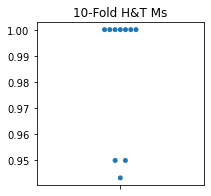

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
htm_scorer = metrics.make_scorer(hand_and_till_M_statistic,
                                needs_proba=True)
cv_auc = skms.cross_val_score(model,
                             iris.data, iris.target,
                             scoring=htm_scorer, cv=10)

sns.swarmplot(cv_auc, orient='v')
ax.set_title('10-Fold H&T Ms');

### 6.5.2 Precision-Recall Curve

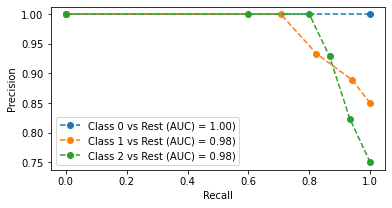

In [24]:
fig, ax = plt.subplots(figsize=(6,3))
for cls in [0, 1, 2]:
    prc = metrics.precision_recall_curve
    precision, recall, _ = prc(im_test_tgt[:,cls],
                              preds_probs[:,cls])
    prc_auc = metrics.auc(recall, precision)
    label = "Class {} vs Rest (AUC) = {:.2f})".format(cls, prc_auc)
    ax.plot(recall, precision, 'o--', label=label)
ax.legend()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision');

### 6.6 Cumulative Response and Lift Curves

In [25]:
# negate b/c we want big values first
myorder = np.argsort(-prob_true)

# cumulative sum then to percent (last value is total)
realpct_myorder = iris_1c_test_tgt[myorder].cumsum()
realpct_myorder = realpct_myorder / realpct_myorder[-1]

# convert counts of data into percents
N = iris_1c_test_tgt.size
xs = np.linspace(1/N, 1, N)

print(myorder[:3])

[ 0 28 43]


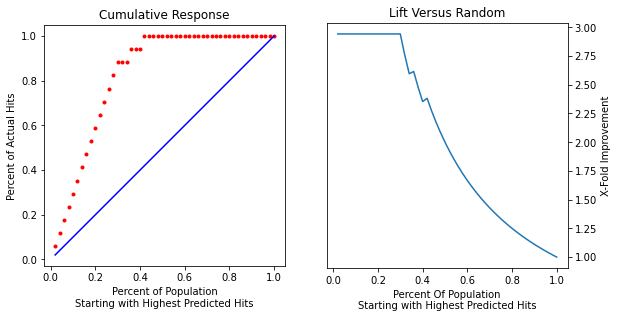

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.tight_layout()

# cumulative response
ax1.plot(xs, realpct_myorder, 'r.')
ax1.plot(xs, xs, 'b-')
ax1.axes.set_aspect('equal')

ax1.set_title("Cumulative Response")
ax1.set_ylabel("Percent of Actual Hits")
ax1.set_xlabel("Percent of Population\n" +
              "Starting with Highest Predicted Hits")

# lift
# replace divide by zero with 1.0
ax2.plot(xs, realpct_myorder / np.where(xs > 0, xs, 1))

ax2.set_title("Lift Versus Random")
ax2.set_ylabel("X-Fold Improvement") # not cross-fold!
ax2.set_xlabel("Percent Of Population\n" +
              "Starting with Highest Predicted Hits")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right');


### 6.7 More Sophisticated Evaluation of Classifiers: Take Two

In [27]:
classifiers = {'base'  :  baseline,
               'gnb'  :  naive_bayes.GaussianNB(),
               '3-NN'  :  neighbors.KNeighborsClassifier(n_neighbors=3),
               '10-NN'  :  neighbors.KNeighborsClassifier(n_neighbors=10)}

In [28]:
# define the one_class iris problem so we don't have random == 1 around
iris_onec_ftrs = iris.data
iris_onec_tgt = iris.target==1

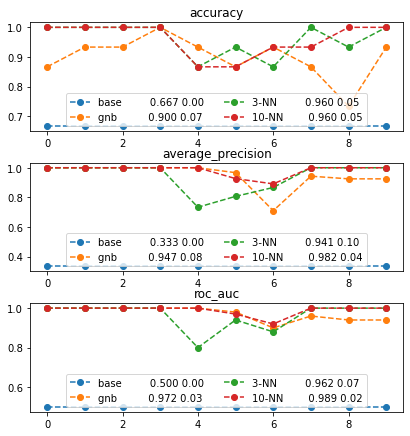

In [29]:
msrs = ['accuracy', 'average_precision', 'roc_auc']

fig, axes = plt.subplots(len(msrs), 1, figsize=(6, 2*len(msrs)))
fig.tight_layout()

for mod_name, model in classifiers.items():
    # abbreviate
    cvs = skms.cross_val_score
    cv_results = {msr:cvs(model, iris_onec_ftrs, iris_onec_tgt,
                         scoring=msr, cv=10) for msr in msrs}
    
    for ax, msr in zip(axes, msrs):
        msr_results = cv_results[msr]
        my_lbl = "{:12s} {:.3f} {:.2f}".format(mod_name,
                                              msr_results.mean(),
                                              msr_results.std())
        ax.plot(msr_results, 'o--', label=my_lbl)
        ax.set_title(msr)
        ax.legend(loc='lower center', ncol=2)

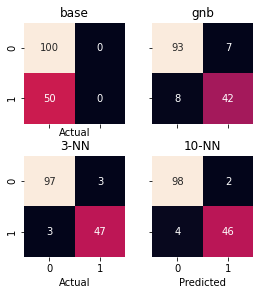

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(4,4), sharex=True, sharey=True)
fig.tight_layout()

for ax, (mod_name, model) in zip(axes.flat, classifiers.items()):
    preds = skms.cross_val_predict(model,
                                  iris_onec_ftrs, iris_onec_tgt,
                                  cv=10)
    
    cm = metrics.confusion_matrix(iris.target==1, preds)
    sns.heatmap(cm, annot=True, ax=ax,
                   cbar=False, square=True, fmt="d")
    
    ax.set_title(mod_name)
    
axes[1, 0].set_xlabel('Predicted')
axes[1, 1].set_xlabel('Predicted')
axes[0, 0].set_xlabel('Actual')
axes[1, 0].set_xlabel('Actual');

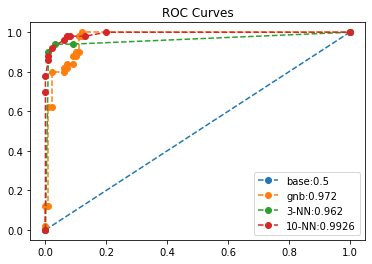

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

cv_prob_true = {}
for mod_name, model in classifiers.items():
    cv_probs = skms.cross_val_predict(model,
                                      iris_onec_ftrs, iris_onec_tgt,
                                      cv=10, method='predict_proba')
    cv_prob_true[mod_name] = cv_probs[:,1]
    
    fpr, tpr, thresh = metrics.roc_curve(iris_onec_tgt,
                                         cv_prob_true[mod_name])
    
    auc = metrics.auc(fpr,tpr)
    ax.plot(fpr, tpr, 'o--', label="{}:{}".format(mod_name, auc))
    
ax.set_title('ROC Curves')
ax.legend();

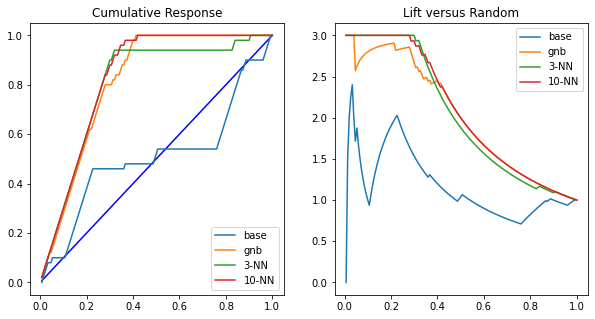

In [34]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))

N = len(iris_onec_tgt)
xs = np.linspace(1/N, 1, N)

ax1.plot(xs, xs, 'b-')

for mod_name in classifiers:
    #negate so big values come first
    myorder = np.argsort(-cv_prob_true[mod_name])
    
    #cumulative sum then to percent (last value is total)
    realpct_myorder = iris_onec_tgt[myorder].cumsum()
    realpct_myorder = realpct_myorder / realpct_myorder[-1]
    
    ax1.plot(xs, realpct_myorder, '-', label=mod_name)
    
    ax2.plot(xs,
             realpct_myorder / np.where(xs > 0, xs, 1),
             label=mod_name)
    
ax1.legend()
ax2.legend()

ax1.set_title("Cumulative Response")
ax2.set_title("Lift versus Random");


### 6.7.2 A Novel Multiclass Problem

In [58]:
#preprocessing data to remove non-numerical features and
#produce discrete target class

raw_loc = 'data/student/student-mat.csv'

def grab_student_numeric_discrete():
    #preprocessing
    df = pd.read_csv(raw_loc, sep=';')
    
    #g1 and g2 are highly correlated with g3;
    #dropping them makes the problem significantly harder
    #we also remove all non-numeric columns
    #and discretize the final grade by 0-50-75-100 percentile
    #which were determined by hand
    
    df = df.drop(columns=['G1', 'G2']).select_dtypes(include=['number'])
    df['grade'] = pd.cut(df['G3'], [0, 11, 14, 20],
                         labels=['low', 'mid', 'high'],
                         include_lowest=True)
    df.drop(columns=['G3'], inplace=True)
    
    #save as
    df.to_csv('data/student/portuguese_student_numeric_discrete.csv', index=False)
    
grab_student_numeric_discrete()

In [59]:
student_df = pd.read_csv('data/student/portuguese_student_numeric_discrete.csv')
student_df['grade'] = pd.Categorical(student_df['grade'],
                                     categories=['low', 'med', 'high'],
                                     ordered=True)

In [60]:
student_ftrs = student_df[student_df.columns[:-1]]
student_tgt = student_df['grade'].cat.codes

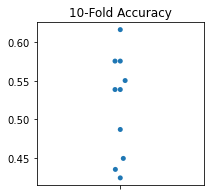

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
model = neighbors.KNeighborsClassifier(3)

cv_auc = skms.cross_val_score(model,
                              student_ftrs, student_tgt,
                              scoring='accuracy', cv=10)
ax = sns.swarmplot(cv_auc, orient='v')
ax.set_title('10-Fold Accuracy');

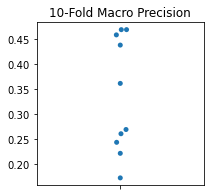

In [62]:
model = neighbors.KNeighborsClassifier(3)
my_scorer = metrics.make_scorer(metrics.precision_score,
                                average='macro')
cv_auc = skms.cross_val_score(model,
                              student_ftrs, student_tgt,
                              scoring=my_scorer, cv=10)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.swarmplot(cv_auc, orient='v')
ax.set_title('10-Fold Macro Precision');

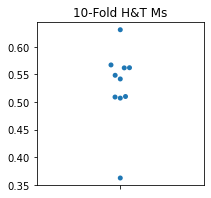

In [63]:
htm_scorer = metrics.make_scorer(hand_and_till_M_statistic,
                                 needs_proba=True)
cv_auc = skms.cross_val_score(model,
                              student_ftrs, student_tgt,
                              scoring=htm_scorer, cv=10)
fig, ax = plt.subplots(1, 1, figsize=(3,3))
sns.swarmplot(cv_auc, orient='v')
ax.set_title('10-Fold H&T Ms');

In [64]:
classifiers = {'base' : dummy.DummyClassifier(strategy='most_frequent'),
               'gnb' : naive_bayes.GaussianNB(),
               '3-NN' : neighbors.KNeighborsClassifier(3),
               '10-NN' : neighbors.KNeighborsClassifier(10)}

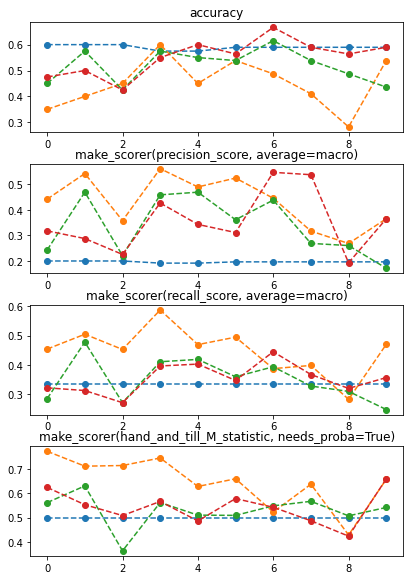

In [65]:
macro_precision = metrics.make_scorer(metrics.precision_score,
                                      average='macro')
macro_recall = metrics.make_scorer(metrics.recall_score,
                                      average='macro')
htm_scorer = metrics.make_scorer(hand_and_till_M_statistic,
                                 needs_proba=True)

msrs = ['accuracy', macro_precision,
       macro_recall, htm_scorer]

fig, axes = plt.subplots(len(msrs), 1, figsize=(6, 2*len(msrs)))
fig.tight_layout()

for mod_name, model in classifiers.items():
    # abbreviate
    cvs = skms.cross_val_score
    cv_results = {msr:cvs(model, student_ftrs, student_tgt,
                         scoring=msr, cv=10) for msr in msrs}
    
    for ax, msr in zip(axes, msrs):
        msr_results = cv_results[msr]
        my_lbl = "{:12s} {:.3f} {:.2f}".format(mod_name,
                                              msr_results.mean(),
                                              msr_results.std())
        
        ax.plot(msr_results, 'o--')
        ax.set_title(msr)




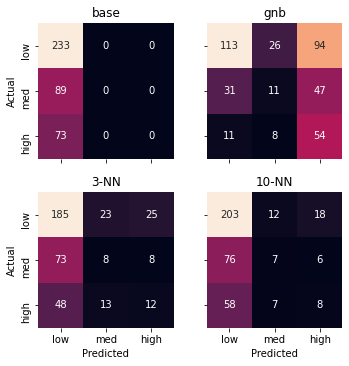

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5), sharex=True, sharey=True)
fig.tight_layout()

for ax, (mod_name, model) in zip(axes.flat,
                                classifiers.items()):
    preds = skms.cross_val_predict(model,
                                  student_ftrs, student_tgt,
                                  cv=10)
    
    cm = metrics.confusion_matrix(student_tgt, preds)
    sns.heatmap(cm, annot=True, ax=ax,
               cbar=False, square=True, fmt='d',
               xticklabels=['low', 'med', 'high'],
               yticklabels=['low', 'med', 'high'])
    ax.set_title(mod_name)
    
axes[1, 0].set_xlabel('Predicted')
axes[1, 1].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[1, 0].set_ylabel('Actual');


### Wine Dataset

In [123]:
wine = datasets.load_wine()

tts = skms.train_test_split(wine.data, wine.target,
                           test_size=.33, random_state=27)

(wine_train_ftrs, wine_test_ftrs,
wine_train_tgt, wine_test_tgt) = tts

# normal usage: build-fit-predict-evaluate
baseline = dummy.DummyClassifier(strategy="most_frequent")
baseline.fit(wine_train_ftrs, wine_train_tgt)
base_preds = baseline.predict(wine_test_ftrs)

base_acc = metrics.accuracy_score(base_preds, wine_test_tgt)
print(base_acc)

0.3728813559322034


In [152]:
wine.target[129]

1

In [153]:
strategies = ['constant', 'uniform', 'stratified',
             'prior', 'most_frequent']

# set up args to create different DummyClassifier strategies
baseline_args = [{'strategy':s} for s in strategies]
baseline_args[0]['constant'] = 0 #for class 0 in dataset

accuracies = []
for bla in baseline_args:
    baseline = dummy.DummyClassifier(**bla)
    baseline.fit(wine_train_ftrs, wine_train_tgt)
    base_preds = baseline.predict(wine_test_ftrs)
    accuracies.append(metrics.accuracy_score(base_preds, wine_test_tgt))
    
display(pd.DataFrame({'accuracy':accuracies}, index=strategies))
#uniform and stratified will return different results if rerun bc they are 
#randomized methods - others return fixed vals

,accuracy
constant,0.2712
uniform,0.3051
stratified,0.2881
prior,0.3729
most_frequent,0.3729


In [154]:
tgt_preds = (neighbors.KNeighborsClassifier()
                      .fit(wine_train_ftrs, wine_train_tgt)
                      .predict(wine_test_ftrs))
             
print("accuracy:", metrics.accuracy_score(wine_test_tgt,
                                         tgt_preds))
             
cm = metrics.confusion_matrix(wine_test_tgt, 
                              tgt_preds)

print("confusion matrix:", cm, sep='\n')

accuracy: 0.5932203389830508
confusion matrix:
[[14  0  2]
 [ 2 15  5]
 [ 3 12  6]]


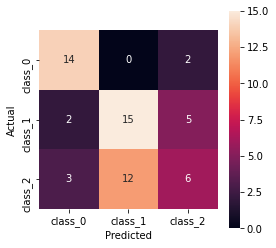

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
cm = metrics.confusion_matrix(wine_test_tgt, tgt_preds)
ax = sns.heatmap(cm, annot=True, square=True,
                xticklabels=wine.target_names,
                yticklabels=wine.target_names)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

In [156]:
print(metrics.classification_report(wine_test_tgt,
                                   tgt_preds))
#average is a weighted macro average (see text)

#verify sums-across-rows
cm = metrics.confusion_matrix(wine_test_tgt, tgt_preds)
print("row counts equal support:", cm.sum(axis=1))

              precision    recall  f1-score   support

           0       0.74      0.88      0.80        16
           1       0.56      0.68      0.61        22
           2       0.46      0.29      0.35        21

    accuracy                           0.59        59
   macro avg       0.58      0.61      0.59        59
weighted avg       0.57      0.59      0.57        59

row counts equal support: [16 22 21]


In [157]:
checkout = [0, 59, 130]
print("Original Encoding")
print(wine.target[checkout])

Original Encoding
[0 1 2]


In [158]:
print("'Multi-label' Encoding")
print(skpre.label_binarize(wine.target, [0, 1, 2])[checkout])

'Multi-label' Encoding
[[1 0 0]
 [0 1 0]
 [0 0 1]]


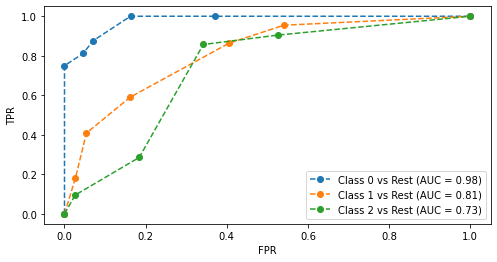

In [160]:
wine_multi_tgt = skpre.label_binarize(wine.target, [0, 1, 2])

#wm --> "wine multi"
(wm_train_ftrs, wm_test_ftrs,
wm_train_tgt, wm_test_tgt) = skms.train_test_split(wine.data,
                                                  wine_multi_tgt,
                                                  test_size=.33,
                                                  random_state=27)

#knn wrapped up in one-versus-rest (3 classifiers)
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
ovr_knn = skmulti.OneVsRestClassifier(knn)
preds_probs = (ovr_knn.fit(wm_train_ftrs, wm_train_tgt)
                      .predict_proba(wm_test_ftrs))

#make ROC plots
lbl_fmt = "Class {} vs Rest (AUC = {:.2f})"
fig, ax = plt.subplots(figsize=(8,4))
for cls in [0, 1, 2]:
    fpr, tpr, _ = metrics.roc_curve(wm_test_tgt[:,cls],
                                   preds_probs[:,cls])
    label = lbl_fmt.format(cls, metrics.auc(fpr, tpr))
    ax.plot(fpr, tpr, 'o--', label=label)
ax.legend()
ax.set_xlabel("FPR")
ax.set_ylabel("TPR");

In [161]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
ovo_knn = skmulti.OneVsOneClassifier(knn)

pred_scores = (ovo_knn.fit(wine_train_ftrs, wine_train_tgt)
                      .decision_function(wine_test_ftrs))
df = pd.DataFrame(pred_scores)
df['class'] = df.values.argmax(axis=1)
display(df.head())

,0,1,2,class
0,2.0000,0.9048,0.0952,0
1,-0.2051,2.0952,1.1818,1
2,1.8750,-0.0952,1.1667,0
3,-0.2222,1.0952,2.2051,2
4,2.0000,0.9048,0.0952,0


In [162]:
mi = pd.MultiIndex([['Class Indicator', 'Vote'], [0, 1, 2]],
                  [[0]*3+[1]*3, list(range(3)) * 2])
df = pd.DataFrame(np.c_[wm_test_tgt, pred_scores],
                 columns=mi)
display(df.head())

Class Indicator                                            \
                     0                    1                    2   
0               1.0000               0.0000               0.0000   
1               0.0000               1.0000               0.0000   
2               0.0000               0.0000               1.0000   
3               0.0000               1.0000               0.0000   
4               1.0000               0.0000               0.0000   

                  Vote                                            
                     0                    1                    2  
0               2.0000               0.9048               0.0952  
1              -0.2051               2.0952               1.1818  
2               1.8750              -0.0952               1.1667  
3              -0.2222               1.0952               2.2051  
4               2.0000               0.9048               0.0952

In [174]:
print(len(wm_test_tgt))
print(len(pred_scores))

59
59


In [175]:
knn = neighbors.KNeighborsClassifier()
knn.fit(wine_train_ftrs, wine_train_tgt)
test_probs = knn.predict_proba(wine_test_ftrs)
hand_and_till_M_statistic(wine_test_tgt, test_probs)

0.853648088023088

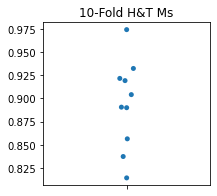

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
htm_scorer = metrics.make_scorer(hand_and_till_M_statistic,
                                needs_proba=True)
cv_auc = skms.cross_val_score(model,
                             wine.data, wine.target,
                             scoring=htm_scorer, cv=10)

sns.swarmplot(cv_auc, orient='v')
ax.set_title('10-Fold H&T Ms');

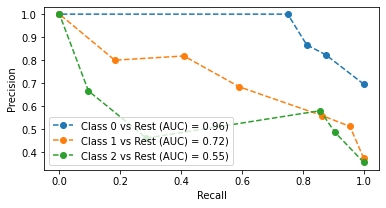

In [166]:
fig, ax = plt.subplots(figsize=(6,3))
for cls in [0, 1, 2]:
    prc = metrics.precision_recall_curve
    precision, recall, _ = prc(wm_test_tgt[:,cls],
                              preds_probs[:,cls])
    prc_auc = metrics.auc(recall, precision)
    label = "Class {} vs Rest (AUC) = {:.2f})".format(cls, prc_auc)
    ax.plot(recall, precision, 'o--', label=label)
ax.legend()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision');

In [177]:
#create the OvO 
is_class1= wine.target == 1

tts_1c = skms.train_test_split(wine.data, is_class1,
                              test_size=.33, random_state = 27)

(wine_1c_train_ftrs, wine_1c_test_ftrs,
wine_1c_train_tgt, wine_1c_test_tgt) = tts_1c

# build, fit, predict (probability scores) for NB model
gnb = naive_bayes.GaussianNB()
prob_true = (gnb.fit(wine_1c_train_ftrs, wine_1c_train_tgt)
                .predict_proba(wine_1c_test_ftrs)[:,1])

# negate b/c we want big values first
myorder = np.argsort(-prob_true)

# cumulative sum then to percent (last value is total)
realpct_myorder = wine_1c_test_tgt[myorder].cumsum()
realpct_myorder = realpct_myorder / realpct_myorder[-1]

# convert counts of data into percents
N = wine_1c_test_tgt.size
xs = np.linspace(1/N, 1, N)

print(myorder[:3])

[48 20 41]


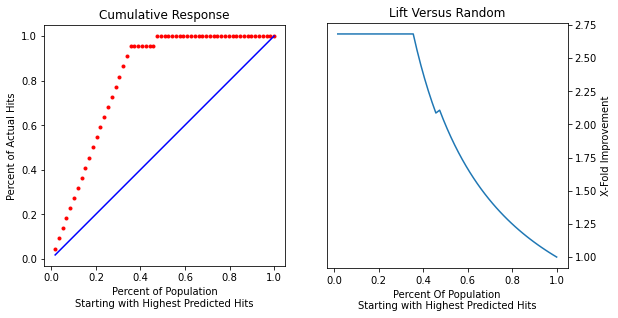

In [178]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.tight_layout()

# cumulative response
ax1.plot(xs, realpct_myorder, 'r.')
ax1.plot(xs, xs, 'b-')
ax1.axes.set_aspect('equal')

ax1.set_title("Cumulative Response")
ax1.set_ylabel("Percent of Actual Hits")
ax1.set_xlabel("Percent of Population\n" +
              "Starting with Highest Predicted Hits")

# lift
# replace divide by zero with 1.0
ax2.plot(xs, realpct_myorder / np.where(xs > 0, xs, 1))

ax2.set_title("Lift Versus Random")
ax2.set_ylabel("X-Fold Improvement") # not cross-fold!
ax2.set_xlabel("Percent Of Population\n" +
              "Starting with Highest Predicted Hits")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right');

In [179]:
classifiers = {'base'  :  baseline,
               'gnb'  :  naive_bayes.GaussianNB(),
               '3-NN'  :  neighbors.KNeighborsClassifier(n_neighbors=3),
               '10-NN'  :  neighbors.KNeighborsClassifier(n_neighbors=10)}

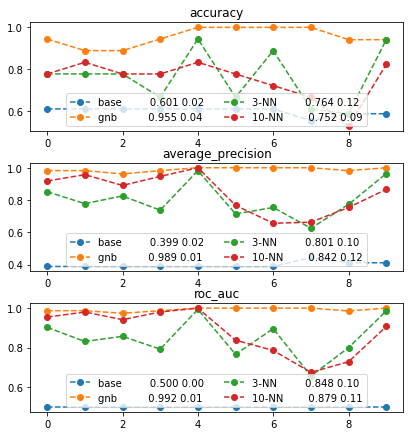

In [180]:
# define the one_class iris problem so we don't have random == 1 around
wine_onec_ftrs = wine.data
wine_onec_tgt = wine.target==1

msrs = ['accuracy', 'average_precision', 'roc_auc']

fig, axes = plt.subplots(len(msrs), 1, figsize=(6, 2*len(msrs)))
fig.tight_layout()

for mod_name, model in classifiers.items():
    # abbreviate
    cvs = skms.cross_val_score
    cv_results = {msr:cvs(model, wine_onec_ftrs, wine_onec_tgt,
                         scoring=msr, cv=10) for msr in msrs}
    
    for ax, msr in zip(axes, msrs):
        msr_results = cv_results[msr]
        my_lbl = "{:12s} {:.3f} {:.2f}".format(mod_name,
                                              msr_results.mean(),
                                              msr_results.std())
        ax.plot(msr_results, 'o--', label=my_lbl)
        ax.set_title(msr)
        ax.legend(loc='lower center', ncol=2)

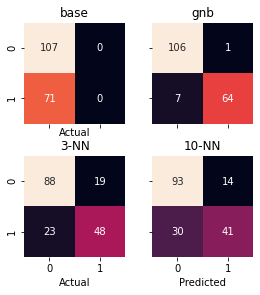

In [181]:
fig, axes = plt.subplots(2, 2, figsize=(4,4), sharex=True, sharey=True)
fig.tight_layout()

for ax, (mod_name, model) in zip(axes.flat, classifiers.items()):
    preds = skms.cross_val_predict(model,
                                  wine_onec_ftrs, wine_onec_tgt,
                                  cv=10)
    
    cm = metrics.confusion_matrix(wine.target==1, preds)
    sns.heatmap(cm, annot=True, ax=ax,
                   cbar=False, square=True, fmt="d")
    
    ax.set_title(mod_name)
    
axes[1, 0].set_xlabel('Predicted')
axes[1, 1].set_xlabel('Predicted')
axes[0, 0].set_xlabel('Actual')
axes[1, 0].set_xlabel('Actual');

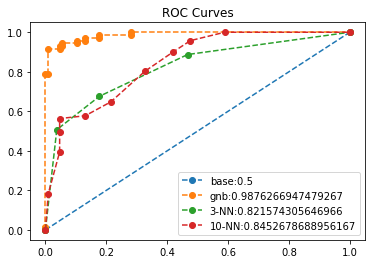

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

cv_prob_true = {}
for mod_name, model in classifiers.items():
    cv_probs = skms.cross_val_predict(model,
                                      wine_onec_ftrs, wine_onec_tgt,
                                      cv=10, method='predict_proba')
    cv_prob_true[mod_name] = cv_probs[:,1]
    
    fpr, tpr, thresh = metrics.roc_curve(wine_onec_tgt,
                                         cv_prob_true[mod_name])
    
    auc = metrics.auc(fpr,tpr)
    ax.plot(fpr, tpr, 'o--', label="{}:{}".format(mod_name, auc))
    
ax.set_title('ROC Curves')
ax.legend();

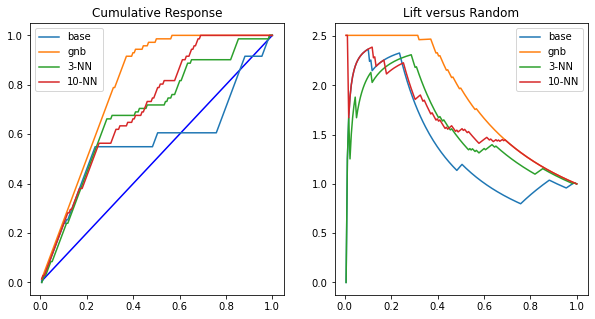

In [183]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))

N = len(wine_onec_tgt)
xs = np.linspace(1/N, 1, N)

ax1.plot(xs, xs, 'b-')

for mod_name in classifiers:
    #negate so big values come first
    myorder = np.argsort(-cv_prob_true[mod_name])
    
    #cumulative sum then to percent (last value is total)
    realpct_myorder = wine_onec_tgt[myorder].cumsum()
    realpct_myorder = realpct_myorder / realpct_myorder[-1]
    
    ax1.plot(xs, realpct_myorder, '-', label=mod_name)
    
    ax2.plot(xs,
             realpct_myorder / np.where(xs > 0, xs, 1),
             label=mod_name)
    
ax1.legend()
ax2.legend()

ax1.set_title("Cumulative Response")
ax2.set_title("Lift versus Random");